In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
#loading the data
weekly_data = pd.read_csv('../data/featured-data.csv')
weekly_data['timestamp'] = pd.to_datetime(weekly_data['timestamp'])

# filter athletes with enough data (≥7 weeks for 6-week lookback)
athlete_weeks = weekly_data.groupby('athlete').size()
valid_athletes = athlete_weeks[athlete_weeks >= 7].index
lstm_data = weekly_data[weekly_data['athlete'].isin(valid_athletes)].copy()

print(f"Loaded {len(weekly_data)} total weeks")
print(f"Using {len(valid_athletes)} athletes with ≥7 weeks")
print(f"Final dataset: {len(lstm_data)} weeks")
print(f"\nSample data:")
print(lstm_data.head())

Loaded 14234 total weeks
Using 112 athletes with ≥7 weeks
Final dataset: 14220 weeks

Sample data:
   athlete  timestamp  weekly_distance_m  weekly_mileage  weekly_time_s  \
0   771514 2017-02-13             5355.4        3.327690           3371   
1   771514 2017-06-26             6243.5        3.879530           2137   
2   771514 2017-07-03             6630.2        4.119814           2306   
3   771514 2017-07-10            16955.9       10.535905           6086   
4   771514 2017-07-17             6191.1        3.846970           2216   

   avg_weekly_pace_km  avg_weekly_pace_mile  weekly_elevation_m  \
0           10.490969             16.883583                81.6   
1            5.628635              9.058413                37.2   
2            5.796708              9.328900                95.6   
3            5.964640              9.599160               177.8   
4            5.965553              9.600629                57.3   

   average heart rate (bpm)  training_days  wee

In [3]:
def create_sequences(athlete_data, feature_col='weekly_mileage', lookback=6):
    """
    Transform weekly data into LSTM sequences
    
    Example transformation:
    Input data:  [10, 12, 15, 18, 20, 22, 25, 28, 30]
    
    Output:
      X: [[10, 12, 15, 18, 20, 22],
          [12, 15, 18, 20, 22, 25],
          [15, 18, 20, 22, 25, 28]]
      
      y: [25, 28, 30]
    
    Args:
        athlete_data: DataFrame for single athlete (sorted by timestamp)
        feature_col: Column name to create sequences from
        lookback: Number of past weeks to use for prediction
    
    Returns:
        X: numpy array of shape (n_sequences, lookback)
        y: numpy array of shape (n_sequences,)
    """
    data = athlete_data[feature_col].values
    X, y = [], []
    
    # Slide a window through the data
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    
    return np.array(X), np.array(y)

# Test function with one athlete
test_athlete_id = valid_athletes[0]
test_data = lstm_data[lstm_data['athlete'] == test_athlete_id].sort_values('timestamp')
X_test, y_test = create_sequences(test_data, lookback=6)

print(f"Sequence function created!")
print(f"\nTest with athlete {test_athlete_id}:")
print(f"Athlete has {len(test_data)} weeks of data")
print(f"Created {len(X_test)} sequences")
print(f"\nFirst sequence (X): {X_test[0]}")
print(f"First target (y): {y_test[0]}")

Sequence function created!

Test with athlete 771514:
Athlete has 41 weeks of data
Created 35 sequences

First sequence (X): [ 3.32769025  3.87952984  4.119814   10.53590454  3.84697     4.87353703]
First target (y): 4.0626478722


In [4]:
# create sequences for all athletes and combine
X_all, y_all = [], []

print("Creating sequences for all athletes...")

for i, athlete_id in enumerate(valid_athletes):
    # getting all the athlete's data sorted by time
    athlete_data = lstm_data[lstm_data['athlete'] == athlete_id].sort_values('timestamp')
    
    # creating the sequences
    X_seq, y_seq = create_sequences(athlete_data, feature_col='weekly_mileage', lookback=6)
    
    # only adding if there are sequences
    if len(X_seq) > 0:
        X_all.append(X_seq)
        y_all.append(y_seq)
    
    # progress update every 20 athletes
    if (i + 1) % 20 == 0:
        print(f"  Processed {i + 1}/{len(valid_athletes)} athletes...")

# concatenate all sequences to final arrays
X = np.concatenate(X_all, axis=0)
y = np.concatenate(y_all, axis=0)

print(f"\nCreated sequences for all athletes!")
print(f"\nDataset shapes:")
print(f"   X: {X.shape} (samples, lookback)")
print(f"   y: {y.shape} (samples,)")
print(f"\nStatistics:")
print(f"   Total sequences: {len(X):,}")
print(f"   Mileage range: {y.min():.1f} - {y.max():.1f} miles")
print(f"   Mean mileage: {y.mean():.1f} miles")
print(f"   Median mileage: {np.median(y):.1f} miles")

Creating sequences for all athletes...
  Processed 20/112 athletes...
  Processed 40/112 athletes...
  Processed 60/112 athletes...
  Processed 80/112 athletes...
  Processed 100/112 athletes...

Created sequences for all athletes!

Dataset shapes:
   X: (13548, 6) (samples, lookback)
   y: (13548,) (samples,)

Statistics:
   Total sequences: 13,548
   Mileage range: 3.0 - 69.7 miles
   Mean mileage: 19.2 miles
   Median mileage: 17.2 miles


In [5]:
# Scaling the features to 0-1 range
print("Scaling data...")

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# fit and transform
X_scaled = scaler_X.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# reshape X for LSTM: (samples, timesteps, features)
# LSTM expects 3D input: [batch_size, sequence_length, num_features]
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

print(f"Data scaled successfully!")
print(f"\nScaled shapes:")
print(f"   X: {X_scaled.shape} (samples, timesteps, features)")
print(f"   y: {y_scaled.shape} (samples,)")
print(f"\nScaled ranges:")
print(f"   X min: {X_scaled.min():.3f}, max: {X_scaled.max():.3f}")
print(f"   y min: {y_scaled.min():.3f}, max: {y_scaled.max():.3f}")

Scaling data...
Data scaled successfully!

Scaled shapes:
   X: (13548, 6, 1) (samples, timesteps, features)
   y: (13548,) (samples,)

Scaled ranges:
   X min: 0.000, max: 1.000
   y min: 0.000, max: 1.000


In [6]:
# split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, 
    test_size=0.2, 
    random_state=42,
    shuffle=True  # shuffle to mix athletes
)

print(f"Train/test split complete!")
print(f"\nDataset sizes:")
print(f"   Training:   {X_train.shape[0]:,} sequences ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Testing:    {X_test.shape[0]:,} sequences ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nSample shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   X_test:  {X_test.shape}")
print(f"   y_test:  {y_test.shape}")

Train/test split complete!

Dataset sizes:
   Training:   10,838 sequences (80.0%)
   Testing:    2,710 sequences (20.0%)

Sample shapes:
   X_train: (10838, 6, 1)
   y_train: (10838,)
   X_test:  (2710, 6, 1)
   y_test:  (2710,)


In [7]:
import joblib
import os

os.makedirs('../models', exist_ok=True)

joblib.dump(scaler_X, '../models/scaler_X.pkl')
joblib.dump(scaler_y, '../models/scaler_y.pkl')

print("Scalers saved to ../models/")
print("\n" + "="*60)
print("="*60)
print("\nSummary:")
print(f"   • Total sequences: {len(X):,}")
print(f"   • Training samples: {len(X_train):,}")
print(f"   • Test samples: {len(X_test):,}")
print(f"   • Input shape: (6 weeks, 1 feature)")
print(f"   • Output: 1 value (next week's mileage)")
print(f"   • Mileage range: {y.min():.1f} - {y.max():.1f} miles")
print(f"   • Mean mileage: {y.mean():.1f} miles")

Scalers saved to ../models/


Summary:
   • Total sequences: 13,548
   • Training samples: 10,838
   • Test samples: 2,710
   • Input shape: (6 weeks, 1 feature)
   • Output: 1 value (next week's mileage)
   • Mileage range: 3.0 - 69.7 miles
   • Mean mileage: 19.2 miles


In [8]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.20.0
GPU available: False


In [10]:
# Define LSTM architecture
model = Sequential([
    # Input layer
    LSTM(units=50, return_sequences=False, input_shape=(6, 1)),
    
    # Dropout for regularization (prevents overfitting)
    Dropout(0.2),
    
    # Output layer
    Dense(units=1)
])

# Compile model
model.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error
    metrics=['mae']  # Mean Absolute Error
)

print("\nModel created successfully!")
print("\nModel Architecture:")
model.summary()


Model created successfully!

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Set up callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    '../models/lstm_model_best.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
print("Training LSTM model...")
print("="*60)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

print("\nTraining complete!")

Training LSTM model...
Epoch 1/100
263/271 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0289 - mae: 0.1289
Epoch 1: val_loss improved from None to 0.01898, saving model to ../models/lstm_model_best.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0221 - mae: 0.1151 - val_loss: 0.0190 - val_mae: 0.1085
Epoch 2/100
269/271 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 - mae: 0.1081
Epoch 2: val_loss improved from 0.01898 to 0.01791, saving model to ../models/lstm_model_best.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0195 - mae: 0.1092 - val_loss: 0.0179 - val_mae: 0.1046
Epoch 3/100
253/271 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199 - mae: 0.1096
Epoch 3: val_loss improved from 0.01791 to 0.01776, saving model to ../models/lstm_model_best.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0193 - mae: 0.1088 - val_loss: 0.0178 - val_mae: 0.1043
Epoch 4/100
262/271 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0196 - mae: 0.1099
Epoch 4: val_loss did not impro

In [12]:
# Evaluate model performance and create visualizations

print("="*60)
print("EVALUATING MODEL PERFORMANCE")
print("="*60)

# 1. Evaluate on test set
print("\nTesting on held-out data...")
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"\nTest Set Metrics (Scaled):")
print(f"   • Loss (MSE): {test_loss:.4f}")
print(f"   • MAE: {test_mae:.4f}")

# 2. Make predictions
print("\nGenerating predictions...")
y_pred_scaled = model.predict(X_test, verbose=0)

# 3. Inverse transform to actual mileage
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# 4. Calculate performance metrics in actual miles
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2 = r2_score(y_test_actual, y_pred)

print(f"\nFINAL PERFORMANCE METRICS:")
print(f"   • Mean Absolute Error (MAE): {mae:.2f} miles")
print(f"   • Root Mean Squared Error (RMSE): {rmse:.2f} miles")
print(f"   • R² Score: {r2:.3f}")
print(f"\nInterpretation:")
print(f"   → On average, predictions are off by {mae:.1f} miles")
print(f"   → Model explains {r2*100:.1f}% of variance in mileage")

# 5. Show sample predictions
print(f"\nSAMPLE PREDICTIONS:")
print(f"{'Actual':<10} {'Predicted':<12} {'Error':<10}")
print("-" * 35)
for i in range(5):
    actual = y_test_actual[i][0]
    predicted = y_pred[i][0]
    error = abs(actual - predicted)
    print(f"{actual:>6.1f} mi  {predicted:>8.1f} mi  {error:>6.1f} mi")

print("\n" + "="*60)

EVALUATING MODEL PERFORMANCE

Testing on held-out data...

Test Set Metrics (Scaled):
   • Loss (MSE): 0.0187
   • MAE: 0.1055

Generating predictions...

FINAL PERFORMANCE METRICS:
   • Mean Absolute Error (MAE): 7.04 miles
   • Root Mean Squared Error (RMSE): 9.12 miles
   • R² Score: 0.414

Interpretation:
   → On average, predictions are off by 7.0 miles
   → Model explains 41.4% of variance in mileage

SAMPLE PREDICTIONS:
Actual     Predicted    Error     
-----------------------------------
  24.7 mi      19.5 mi     5.2 mi
   7.4 mi       8.9 mi     1.5 mi
   4.3 mi      15.5 mi    11.2 mi
  55.1 mi      33.9 mi    21.2 mi
  37.5 mi      43.6 mi     6.1 mi



Creating training history plots...


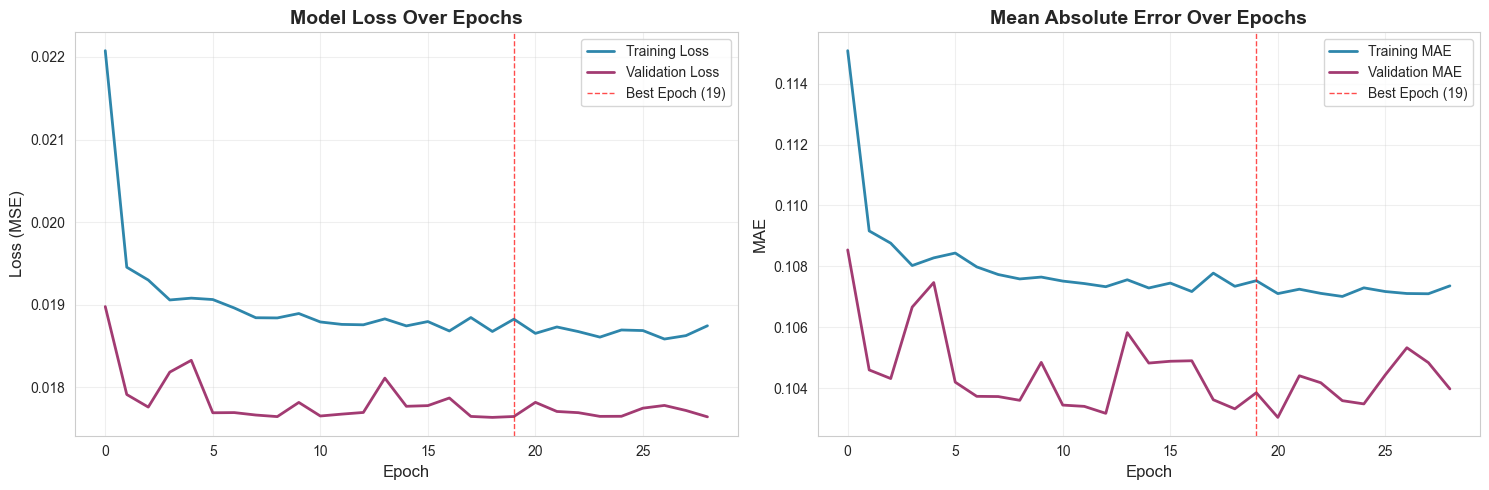

In [13]:
# Plot training history
print("Creating training history plots...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='#2E86AB')
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#A23B72')
ax1.axvline(x=19, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Best Epoch (19)')
ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (MSE)', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# MAE plot
ax2.plot(history.history['mae'], label='Training MAE', linewidth=2, color='#2E86AB')
ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='#A23B72')
ax2.axvline(x=19, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Best Epoch (19)')
ax2.set_title('Mean Absolute Error Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

Creating prediction scatter plot...


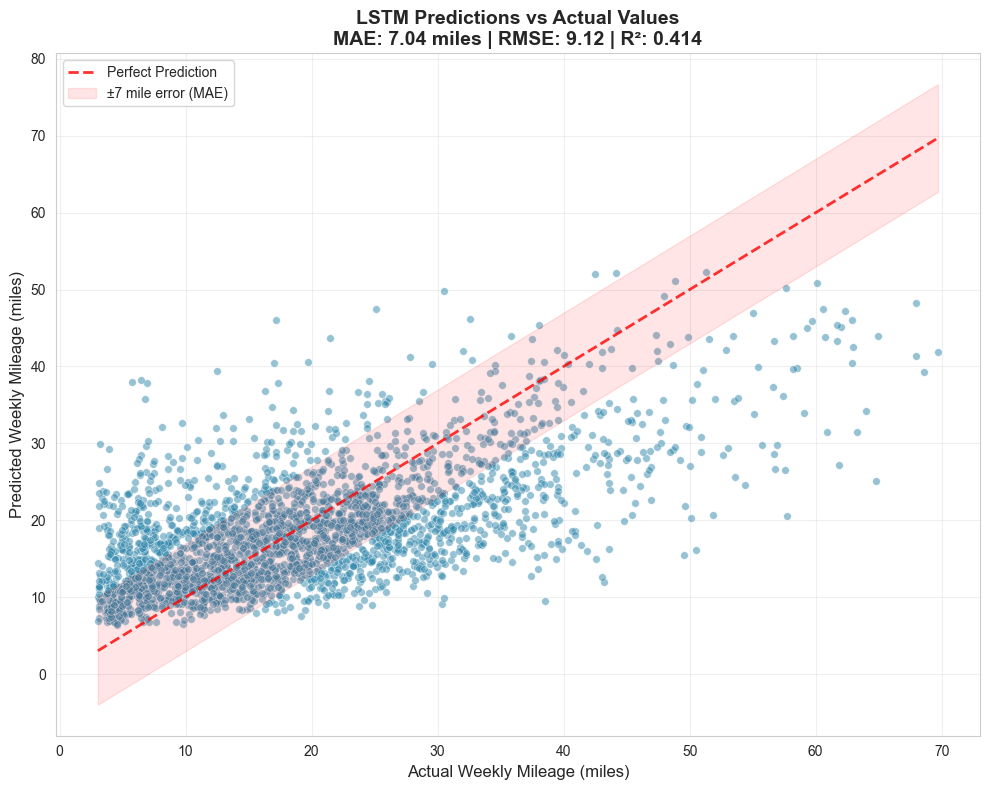

In [14]:
# Plot predictions vs actual values
print("Creating prediction scatter plot...")

plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(y_test_actual, y_pred, alpha=0.5, s=30, color='#2E86AB', edgecolors='white', linewidth=0.5)

# Perfect prediction line
min_val = min(y_test_actual.min(), y_pred.min())
max_val = max(y_test_actual.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction', alpha=0.8)

# Error bands (±7 miles = MAE)
plt.fill_between([min_val, max_val], 
                 [min_val - 7, max_val - 7], 
                 [min_val + 7, max_val + 7], 
                 color='red', alpha=0.1, label='±7 mile error (MAE)')

plt.xlabel('Actual Weekly Mileage (miles)', fontsize=12)
plt.ylabel('Predicted Weekly Mileage (miles)', fontsize=12)
plt.title(f'LSTM Predictions vs Actual Values\nMAE: {mae:.2f} miles | RMSE: {rmse:.2f} | R²: {r2:.3f}', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/lstm_predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

Analyzing prediction errors...


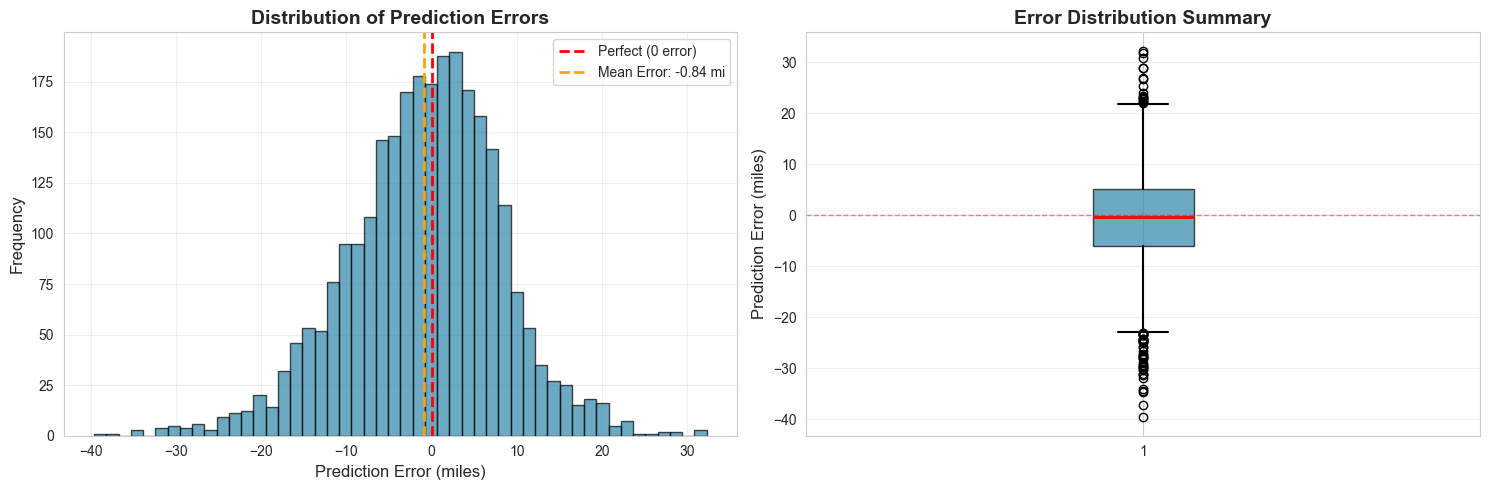

Error distribution saved!

Error Statistics:
   • Mean error: -0.84 miles
   • Median error: -0.32 miles
   • Std deviation: 9.08 miles
   • Min error: -39.64 miles
   • Max error: 32.31 miles
   • % within ±5 miles: 44.9%
   • % within ±10 miles: 76.3%


In [15]:
print("Analyzing prediction errors...")

errors = (y_pred - y_test_actual).flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
ax1.hist(errors, bins=50, color='#2E86AB', alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Perfect (0 error)')
ax1.axvline(x=errors.mean(), color='orange', linestyle='--', linewidth=2, 
            label=f'Mean Error: {errors.mean():.2f} mi')
ax1.set_xlabel('Prediction Error (miles)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Box plot
bp = ax2.boxplot(errors, vert=True, patch_artist=True,
                 boxprops=dict(facecolor='#2E86AB', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5))
ax2.set_ylabel('Prediction Error (miles)', fontsize=12)
ax2.set_title('Error Distribution Summary', fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../visualizations/lstm_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Error distribution saved!")

print(f"\nError Statistics:")
print(f"   • Mean error: {errors.mean():.2f} miles")
print(f"   • Median error: {np.median(errors):.2f} miles")
print(f"   • Std deviation: {errors.std():.2f} miles")
print(f"   • Min error: {errors.min():.2f} miles")
print(f"   • Max error: {errors.max():.2f} miles")
print(f"   • % within ±5 miles: {(np.abs(errors) <= 5).mean() * 100:.1f}%")
print(f"   • % within ±10 miles: {(np.abs(errors) <= 10).mean() * 100:.1f}%")